# Detect the sound of engines with machine learning
<h4>Blake Rayvid - <a href=https://github.com/brayvid>https://github.com/brayvid</a></h4>

# Start from scratch from dataset

In [ ]:
!pip install resampy

In [ ]:
# Generate X and y from audio files - MFCC, mean power, entropy
import os
import numpy as np
import librosa
import logging
from sklearn.preprocessing import LabelEncoder
from scipy.stats import entropy

logging.basicConfig(level=logging.DEBUG)

def extract_features(file_path, max_len=212):
    try:
        # Load audio file
        audio, sample_rate = librosa.load(file_path, sr=44100, res_type='kaiser_fast')

        # Generate MFCC
        mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13, n_fft=2048, hop_length=512)

        # Calculate mean power
        mean_power = np.mean(librosa.feature.rms(y=audio))

        # Calculate entropy
        power_spectrum = np.abs(librosa.stft(audio, n_fft=2048, hop_length=512))**2
        power_distribution = power_spectrum / np.sum(power_spectrum)
        signal_entropy = entropy(np.mean(power_distribution, axis=1))

        # Pad or truncate MFCC
        if mfcc.shape[1] < max_len:
            pad_width = max_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_len]

        # Add mean power and entropy as features
        mean_power_feature = np.full((1, max_len), mean_power)
        entropy_feature = np.full((1, max_len), signal_entropy)
        features = np.vstack((mfcc, mean_power_feature, entropy_feature))

        return features

    except FileNotFoundError:
        logging.error(f"File not found: {file_path}")
        return None
    except ValueError as ve:
        logging.error(f"Value error while processing file {file_path}: {ve}")
        return None
    except Exception as e:
        logging.error(f"Error processing file {file_path}: {e}")
        return None

def load_data(data_dir, max_len=212):
    features = []
    labels = []
    class_names = ['engine', 'non_engine']

    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            if file_path.endswith('.wav'):
                data = extract_features(file_path, max_len=max_len)
                if data is not None:
                    features.append(data)
                    labels.append(class_name)

    return np.array(features), np.array(labels)

# Load data
data_dir = '/content/drive/MyDrive/PROJECTS/Flatiron/Phase_4_Project/data'
max_len = 212
X, y = load_data(data_dir, max_len=max_len)

if len(X) == 0:
    logging.error("No valid features extracted.")
else:
    logging.info(f"Extracted features from {len(X)} files.")

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)


# Class names
class_names = le.classes_

In [ ]:
import pickle

# Save X and y to files using pickle
with open('/content/drive/MyDrive/PROJECTS/Flatiron/Phase_4_Project/X_engine.pkl', 'wb') as f:
    pickle.dump(X, f)
with open('/content/drive/MyDrive/PROJECTS/Flatiron/Phase_4_Project/y_engine.pkl', 'wb') as f:
    pickle.dump(y, f)

# Start from saved pickle files

In [ ]:
import pickle

# Load X and y from pickle file
with open('/content/drive/MyDrive/PROJECTS/Flatiron/Phase_4_Project/X_engine.pkl', 'rb') as f:
    X = pickle.load(f)
with open('/content/drive/MyDrive/PROJECTS/Flatiron/Phase_4_Project/y_engine.pkl', 'rb') as f:
    y = pickle.load(f)

In [ ]:
from sklearn.model_selection import train_test_split

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

# CNN classifier

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Adjust input shape
num_features = 15  # 13 MFCCs + 1 mean power + 1 entropy
input_shape = (num_features, X_train.shape[2], 1)

# Reshape data
X_train = X_train.reshape(X_train.shape[0], num_features, X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], num_features, X_test.shape[2], 1)

model = Sequential()

# First convolutional layer
model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D((2, 2)))

# Second convolutional layer
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D((2, 2)))

# Third convolutional layer
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D((2, 2)))

# Flatten and dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary of model
model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model with early stopping
history = model.fit(X_train, y_train, epochs=50, validation_split=0.1, callbacks=[early_stopping])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 15, 212, 32)       320       
                                                                 
 batch_normalization (Batch  (None, 15, 212, 32)       128       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 15, 212, 32)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 7, 106, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 106, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 7, 106, 64)        2

## Evaluate

7/7 [==============================] - 0s 43ms/step - loss: 0.1671 - accuracy: 0.9204
Test accuracy: 0.9203979969024658
7/7 [==============================] - 0s 3ms/step
ROC-AUC: 0.7927259887005651
              precision    recall  f1-score   support

      engine       0.68      0.62      0.65        24
  non-engine       0.95      0.96      0.96       177

    accuracy                           0.92       201
   macro avg       0.82      0.79      0.80       201
weighted avg       0.92      0.92      0.92       201



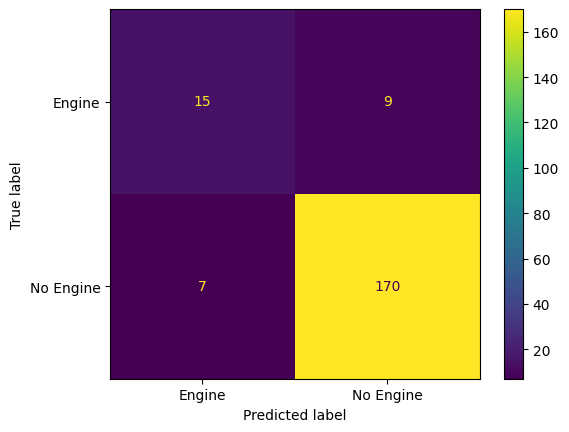

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, classification_report, ConfusionMatrixDisplay

# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

# Get test set predictions
y_pred = np.argmax(model.predict(X_test), axis=1)

# Display ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC: {roc_auc}")

# Classification report
print(classification_report(y_test, y_pred, target_names=['engine', 'non-engine']))

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Engine', 'No Engine'])
plt.show()

# # Plot train and validation accuracy over all epochs
# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.ylim([0, 1])
# plt.legend(loc='lower right')
# plt.show()

## Notes
- <s>Poor recall w/r/t engine class. Misclassifies most true engines.</s> Doing better with the additional features.
- Whether the model classifies engines correctly or not depends strongly on the particular train test split.

# XGBoost classifier ⭐️

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, classification_report, ConfusionMatrixDisplay
import joblib
from xgboost import XGBClassifier
from scipy.stats import uniform, randint

# Assume X and y are already loaded and have the appropriate shapes
# X should be (num_samples, height, width, channels)
# y should be (num_samples,)

# Flatten the image data to 2D array for XGBoost
X_flat = X.reshape(X.shape[0], -1)

# Split the data into training and testing sets with 10% test size
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.1, stratify=y)

# Create a pipeline with StandardScaler and XGBClassifier configured to use GPU
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(eval_metric='logloss', tree_method='hist', device='cuda'))
])

# Define a smaller parameter grid for RandomizedSearchCV
param_dist = {
    'xgb__n_estimators': randint(50, 100),
    'xgb__max_depth': randint(3, 6),
    'xgb__learning_rate': uniform(0.01, 0.1)
}

# Use threading backend to avoid memory issues with loky
with joblib.parallel_backend('threading'):
    random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=10, cv=3, scoring='roc_auc', n_jobs=2)
    random_search.fit(X_train, y_train)

# Save the model for later use
joblib.dump(random_search.best_estimator_, '/content/drive/MyDrive/PROJECTS/Flatiron/Phase_4_Project/xgb_model.pkl')


['xgb_model.pkl']

## Evaluate

Best parameters found:  {'xgb__learning_rate': 0.0965260568447746, 'xgb__max_depth': 4, 'xgb__n_estimators': 94}
Best cross-validation ROC-AUC:  0.9196768840481123
ROC-AUC: 0.8079096045197741
              precision    recall  f1-score   support

      engine       0.64      0.67      0.65        24
  non-engine       0.95      0.95      0.95       177

    accuracy                           0.92       201
   macro avg       0.80      0.81      0.80       201
weighted avg       0.92      0.92      0.92       201



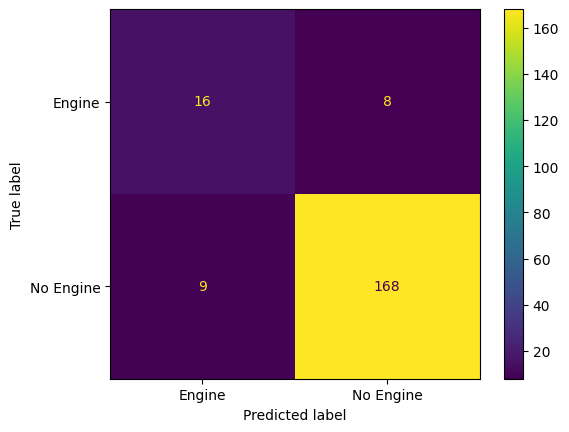

In [ ]:
# Print the best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation ROC-AUC: ", random_search.best_score_)

# Evaluate the model on the test set
xgb_predictions = random_search.predict(X_test)

# Display ROC-AUC
roc_auc = roc_auc_score(y_test, xgb_predictions)
print(f"ROC-AUC: {roc_auc}")

# Classification report
print(classification_report(y_test, xgb_predictions, target_names=['engine', 'non-engine']))

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, xgb_predictions, display_labels=['Engine', 'No Engine'])
plt.show()

## Notes
- <s>Poor recall w/r/t engine class.</s> Fixed with the additional features.


# Model comparison
<table>
<th>Model
<td>ROC-AUC
<td>F1-Engine
<td>Recall-Engine
<td>Best
</th>
<tr>
<td>XGBoost
<td>0.81
<td>0.65
<td>0.67
<td>⭐️
</tr>
<tr>
<td>CNN
<td>0.79
<td>0.65
<td>0.62
<td>
</tr>
</table>

# To do
- <s>Perform more advanced feature extraction before passing to a model.</s> Done.
- Make visualizations and slides for presentation.